# Preliminary

In [1]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from importlib import reload

In [2]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
train_test_split?

In [5]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats],
                                                    bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]),
                                                   random_state=42)

train_pool = cb.Pool(X_train, y_train, cat_features=cat_feats)
test_pool = cb.Pool(X_test, y_test, cat_features=cat_feats)
bb = cb.CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

,metrics,train,test
0,accuracy_score,0.937758,0.905393
1,precision_score,0.838828,0.600000
2,recall_score,0.578283,0.432000
3,y_mean,0.116814,0.110522


# Задача

Найти импликации, гипотезы и ассоциативные правила, которые отражают зависимость целевой переменной $Y$ от конкретных значений признаков и исходных данных $X$.

Для лучшей интерпретабельности желательно использовать как можно меньше признаков и их значений. Для этого нужно отобрать наиболее важные признаки и их наиболее влиятельные значения. Как это сделать? Через Shap.

In [13]:
sv = bb.get_feature_importance(test_pool, type='ShapValues')
expected_value = sv[0,-1]
sv_ds = pd.DataFrame(sv[:,:-1], columns=test_pool.get_feature_names())
sv_ds.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous
0,-0.031291,-0.028272,0.035948,-0.267942,0.101734,-0.268115,0.287815,-0.323185,-0.132049,-0.030460,-0.318450,-0.020844,-1.178477,-0.127363,0.049373,-0.018233
1,0.127565,0.018116,0.079303,-0.008569,0.096851,0.031259,0.187173,0.168337,0.890014,-0.044830,0.208614,-0.046283,1.976521,0.021740,0.050712,0.346256
2,-0.030689,-0.021500,0.028779,0.006304,0.096207,0.052130,0.282196,-0.105999,-0.113547,-0.046154,0.107670,0.009493,-0.678837,0.034704,0.059806,-0.013104
3,0.031418,-0.033332,0.083075,0.001851,-0.065374,0.046528,-0.630254,-0.083773,-0.128123,-0.081089,-0.146013,0.002586,0.676073,-0.356123,0.025053,-0.038261
4,0.007788,0.058849,0.010468,-0.001448,0.106346,0.037828,0.319354,0.229482,-0.117150,-0.034576,0.018484,-0.047470,0.977713,0.028636,0.043395,-0.037927


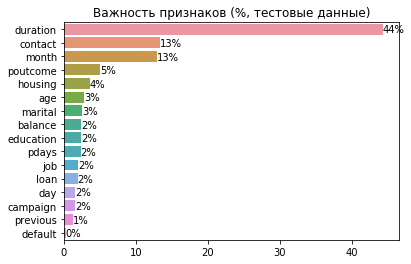

In [39]:
s = sv_ds.abs().median(0).sort_values(ascending=False)
s = s/s.sum()*100
sns.barplot(x=s.values, y=s.index)
for idx, t in enumerate(s.iteritems()):
    plt.text(t[1], idx+0.25, f"{t[1]:.0f}%")
plt.title('Важность признаков (%, тестовые данные)')
plt.show()

Первые 3 признака сильно лидируют по важности (duration, contact, month). Рассмотрим их более детально.

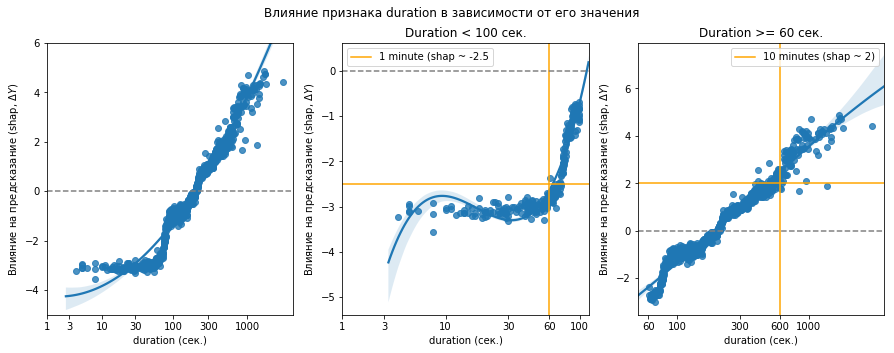

In [127]:
f = 'duration'
cds = pd.DataFrame()
cds[f] = np.log1p(X_test[f])
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,5))
plt.subplot(131)
sns.regplot(x='duration', y=f+'_shap', data=cds, order=2)
xticks = np.array([1, 3,10,30,100,300,1000])
plt.axhline(0, linestyle='--', color='grey')
plt.xticks(np.log1p(xticks), xticks)
plt.ylim((-5,6))
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')

plt.subplot(132)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]<np.log1p(100)], order=3)
xticks = np.array([1, 3,10,30,60,100])
plt.axvline(np.log1p(60), color='orange', label='1 minute (shap ~ -2.5')
plt.axhline(-2.5, color='orange')
plt.legend()
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration < 100 сек.')

plt.xticks(np.log1p(xticks), xticks)

plt.subplot(133)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]>=np.log1p(60)], order=3)
xticks = np.array([60, 100, 300, 600, 1000])
plt.xticks(np.log1p(xticks), xticks)
plt.axvline(np.log1p(600), color='orange', label='10 minutes (shap ~ 2)')
plt.axhline(2, color='orange')
plt.axhline(0, linestyle='--', color='grey')
plt.legend()
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration >= 60 сек.')


plt.suptitle('Влияние признака duration в зависимости от его значения')
plt.show()

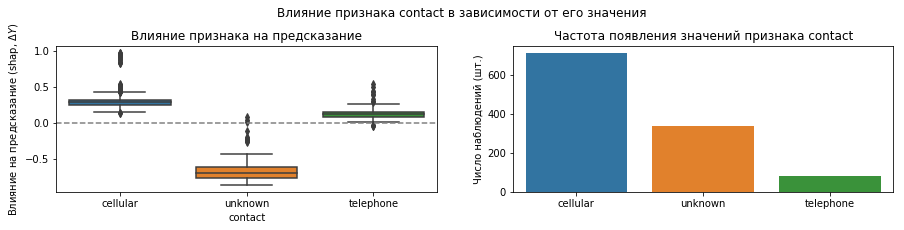

In [159]:
f = 'contact'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,3))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds)
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle('Влияние признака contact в зависимости от его значения')
plt.show()

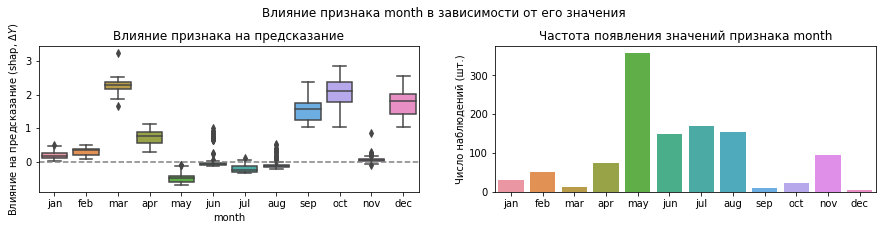

In [161]:
f = 'month'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,3))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
s_ = s_.reindex(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle(f'Влияние признака {f} в зависимости от его значения')
plt.show()